In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as si
from scipy.stats import norm, lognorm
import datetime
from pyfinance.options import BSM
import warnings
warnings.filterwarnings('ignore')

In [ ]:
BSM()

In [2]:
def bs(S, E, T, r, sigma):
    d1 = (np.log(S/E) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = (np.log(S/E) + (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    return S*norm.cdf(d1) - E*np.exp(-r*T)*norm.cdf(d2)

def vol(S, E, r, T, C):
    try:
        return si.optimize.bisect(f=lambda x: bs(S, E, T, r, x+1e-16)-C, a=10e-16, b=1e16)
    except ValueError:
        return np.nan

In [84]:
def read_data(path, sheet):
    file = pd.ExcelFile(path)
    df = file.parse(file.sheet_names[sheet])
    df.columns = ['T', *df.columns[1:-3], 'S', 'r', 'date']
    df.set_index(df['T'], inplace=True)
    return df

def process(df, E):
    df2 = df[['T', *E, 'S', 'r', 'date']]
    #df2 = df2.rename(columns={E:'C'})
    df2['S'] = df2['S']/1000
    df2['T'] = df2['T']/252
    for strike in E:
        df2[strike] = df2[strike]/1000
        #df2[f'sigma{strike}'] = df2.apply(lambda row: vol(row['S'], strike/1000, row['r'], row['T'], row[strike]), axis=1)
        df2[f'sigma{strike}'] = df2.apply(lambda row: BSM(row['S'], strike/1000, row['T'], row['r'], 0.5).implied_vol(row[strike]), axis=1)
    df2 = df2.dropna()
    for strike in E:
        df2 = df2[df2[f'sigma{strike}'] > 0]
        df2 = df2[df2[f'sigma{strike}'] < 0.6]
    return df2

def process_port(df, E):
    df2 = df[['T', E-20, E-10, E, E+10, E+20, 'S', 'r', 'date']]
    df2 = df2.rename(columns={E:'C', E-20: 'C-20', E-10: 'C-10', E+10: 'C+10', E+20: 'C+20'})
    df2['C'] = df2['C']/1000
    df2['S'] = df2['S']/1000
    df2['T'] = df2['T']/252
    df2['sigma'] = df2.apply(lambda row: vol(row['S'], E/1000, row['r'], row['T'], row[strike]), axis=1)
    df2 = df2.dropna()
    df2 = df2[df2['sigma'] > 0]
    #df2 = df2[df2['sigma'] < 0.6]
    return df2

def best_slice(df):
    start      = df.index[0]
    best_start = df.index[0]
    best_end   = df.index[0]
    prev       = df.index[0]
    
    for end in df.index:
        if start - end > best_start - best_end:
                best_start = start
                best_end = end
        if prev - end > 2:
            if start - end > best_start - best_end:
                best_end = prev
            start = end
            
        prev = end
    
    return df.loc[best_start:best_end]

In [55]:
ATM = {
    0:  520, # pm 10, 20, 30, 40
    1:  515, # all
    2:  520, # pm 10, 20, 30, 40
    3:  500, # pm 10, 20, 30, 40
    4:  530, # all
    5:  550, # pm 10, 20, more neg
    6:  520, # pm 10, 20
    7:  500, # all
    8:  485, # all
    9:  490, # pm 10, 20
    10: 515, # all
    11: 535, # all
}

In [5]:
sheet = 10
E = ATM[sheet]
df = read_data('isx2010C.xls', sheet)
df2 = process(df, [E])
df2 = df2.loc[45:]
df2

,T,515,S,r,date,sigma515
T,,,,,,
45,0.178571,0.01590,0.51636,0.15,20.9.2010,0.063183
44,0.174603,0.01565,0.51553,0.15,21.9.2010,0.076909
43,0.170635,0.01455,0.51383,0.15,22.9.2010,0.084999
42,0.166667,0.01280,0.50946,0.15,23.9.2010,0.106189
40,0.158730,0.01570,0.51649,0.16,27.9.2010,0.072913
39,0.154762,0.01620,0.51801,0.16,28.9.2010,0.061175
38,0.150794,0.01580,0.51631,0.16,29.9.2010,0.088812
37,0.146825,0.01470,0.51465,0.16,30.9.2010,0.096592
36,0.142857,0.01570,0.51722,0.16,1.10.2010,0.085452


In [490]:
BSM(S0=0.51934, K=0.515, r=0.16, T=0.162698, sigma=0.2).implied_vol(0.01700)

nan

In [496]:
vol(S=0.51934, E=0.515, r=0.16, T=0.162698, C=0.01700)

nan

In [507]:
amounts = []
skips = 0
new = True
for i, row in df2.iterrows():
    
    if skips == 0 or new:
    
        T = row['T']
        C = row['C']
        S = row['S']
        r = row['r']
        sigma = row['sigma']

        d1 = (np.log(S/(E/1000)) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        delta = norm.cdf(d1)
        
        skips = 0
        new = False
    
    else:
        
        skips += 1
        
    amounts.append(delta)
    
amounts = np.array(amounts)

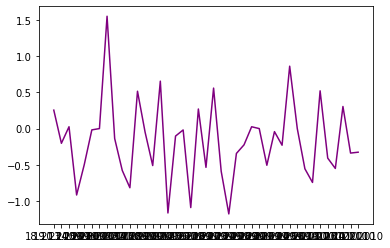

13.685460725328623

In [508]:
underlying_value_changes = df2['S'].values[1:] - df2['S'].values[:-1]
opt_value_changes        = df2['C'].values[1:] - df2['C'].values[:-1]

hedge_value_changes = underlying_value_changes * amounts[:-1]

date = df2['date'].values[1:]

#plt.plot(date, 1000*hedge_value_changes, color='r')
#plt.plot(date, 1000*opt_value_changes, color='b')
plt.plot(date, 1000*opt_value_changes-1000*hedge_value_changes, color='purple')
plt.show()

errors.append(np.sum(np.power(1000*opt_value_changes-1000*hedge_value_changes,2)))
np.sum(np.power(1000*opt_value_changes-1000*hedge_value_changes,2))

In [509]:
errors

[28.29548849044079, 13.685460725328623]

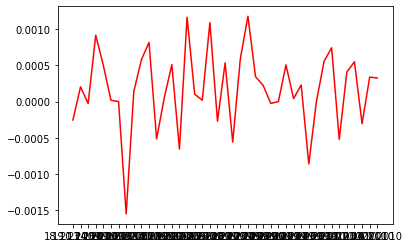

In [399]:
plt.plot(date, hedge_value_changes-opt_value_changes, color='r')
#plt.plot(date, 1000*opt_value_changes, color='b')
plt.show()

In [187]:
old = np.sum(np.power(opt_value_changes-hedge_value_changes,2))

In [191]:
old - np.sum(np.power(opt_value_changes-hedge_value_changes,2))

2.4933658792095515e-05

In [117]:
def delta_hedge(freq):
    errors = []
    changes = []
    for sheet in range(12):

        E = ATM[sheet]
        df = read_data('isx2010C.xls', sheet)
        df2 = process(df, [E])
        df2 = df2.loc[45:]
        #df2 = best_slice(df2)

        amounts = []
        day = 0
        for i, row in df2.iterrows():

            if day % freq == 0:

                T = row['T']
                C = row[E]
                S = row['S']
                r = row['r']
                sigma = row[f'sigma{E}']

                d1 = (np.log(S/(E/1000)) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
                delta = norm.cdf(d1)

            day += 1
            amounts.append(delta)

        amounts = np.array(amounts)
        
        option_value_changes = df2[E].values[1:] - df2[E].values[:-1]
        index_value_changes  = df2['S'].values[1:] - df2['S'].values[:-1]
        hedge_value_changes  = index_value_changes * amounts[:-1]
        
        # Flip sign of option changes due to the position being short
        differences = (1000*(-option_value_changes + hedge_value_changes))
        error = np.mean(np.power(differences, 2))
        
        change = np.sum(np.abs((amounts[1:] - amounts[:-1])*df2['S'].values[1:]))
        
        errors.append(error)
        changes.append(change)
    
    return np.array(errors), np.array(changes)

In [719]:
delta_hedge(1)

<ipython-input-714-d3a0e1f44965>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['S'] = df2['S']/1000
<ipython-input-714-d3a0e1f44965>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['T'] = df2['T']/252
<ipython-input-714-d3a0e1f44965>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

<ipython-input-714-d3a0e1f44965>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[f'sigma{strike}'] = df2.apply(lambda row: vol(row['S'], strike/1000, row['r'], row['T'], row[strike]), axis=1)
<ipython-input-714-d3a0e1f44965>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['S'] = df2['S']/1000
<ipython-input-714-d3a0e1f44965>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

<ipython-input-714-d3a0e1f44965>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[f'sigma{strike}'] = df2.apply(lambda row: vol(row['S'], strike/1000, row['r'], row['T'], row[strike]), axis=1)


array([0.33379173, 0.81276786, 0.73540009, 2.03177181, 3.56513627,
       1.80585317, 1.71372815, 1.27880292, 1.7818616 , 2.91671559,
       1.8863659 , 1.8265127 ])

In [98]:
errors1 = []
errors2 = []
for freq in range(1,11):
    print(freq)
    errors1.append(delta_hedge(freq))
    errors2.append(delta_vega_hedge(freq))

1
2
3
4
5
6
7
8
9
10


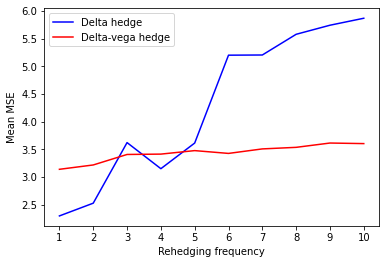

In [101]:
plt.plot(range(1,11),[np.mean(error) for error in errors1], color='blue', label='Delta hedge')
plt.plot(range(1,11),[np.mean([y for y in x if y==y]) for x in errors2], color='red', label='Delta-vega hedge')
plt.xticks(range(1,11))
plt.ylabel('Mean MSE')
plt.xlabel('Rehedging frequency')
plt.legend()
#plt.show()
plt.savefig('single-mean2.jpg', dpi=1000)

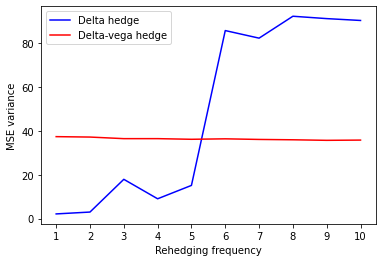

In [102]:
plt.plot(range(1,11),[np.var(error) for error in errors1], color='blue', label='Delta hedge')
plt.plot(range(1,11),[np.var([y for y in x if y==y]) for x in errors2], color='red', label='Delta-vega hedge')
plt.xticks(range(1,11))
plt.ylabel('MSE variance')
plt.xlabel('Rehedging frequency')
plt.legend()
#plt.show()
plt.savefig('single-var2.jpg', dpi=1000)

In [110]:
def delta_vega_hedge(freq):
    errors = []
    i_changes = []
    o_changes = []
    for sheet in range(11):

        E1 = ATM[sheet]
        
        df = read_data('isx2010C.xls', sheet)
        df2 = process(df, [E1])
        
        df = read_data('isx2010C.xls', sheet+1)
        df3 = process(df, [E1])
        
        df4 = pd.merge(df2, df3, on='date')
        
        df4.index = [int(x) for x in df4['T_y']*252]
        df4 = df4.loc[45:]
        #df4 = best_slice(df4)

        i_amounts = []
        o_amounts = []
        day = 0
        for i, row in df4.iterrows():

            if day % freq == 0:

                T1 = row['T_x']
                T2 = row['T_y']
                C1 = row[f'{E1}_x']
                C2 = row[f'{E1}_y']
                S = row['S_x']
                r = row['r_x']
                sigma1 = row[f'sigma{E1}_x']
                sigma2 = row[f'sigma{E1}_y']

                d11 = (np.log(S/(E1/1000)) + (r + 0.5*sigma1**2)*T1)/(sigma1*np.sqrt(T1))
                d12 = (np.log(S/(E1/1000)) + (r + 0.5*sigma2**2)*T2)/(sigma2*np.sqrt(T2))
                delta1 = norm.cdf(d11)
                delta2 = norm.cdf(d12)
                vega1 = S*np.sqrt(T1)*norm.pdf(d11)
                vega2 = S*np.sqrt(T2)*norm.pdf(d12)

            o_amounts.append(vega1/vega2)
            i_amounts.append(delta1-vega1/vega2*delta2)
            day += 1

        i_amounts = np.array(i_amounts)
        o_amounts = np.array(o_amounts)
        
        option_value_changes = df4[f'{E1}_x'].values[1:] - df4[f'{E1}_x'].values[:-1]
        index_value_changes  = df4['S_x'].values[1:] - df4['S_x'].values[:-1]
        repl_value_changes = df4[f'{E1}_y'].values[1:] - df4[f'{E1}_y'].values[:-1]
        hedge_value_changes  = index_value_changes * i_amounts[:-1] + repl_value_changes*o_amounts[:-1]
        
        # Flip sign of option changes due to the position being short
        differences = (1000*(-option_value_changes + hedge_value_changes))
        error = np.nanmean(np.square(differences))
        
        i_change = np.sum(np.abs(i_amounts[1:] - i_amounts[:-1]))
        o_change = np.sum(np.abs(o_amounts[1:] - o_amounts[:-1]))
        
        errors.append(error)
        i_changes.append(i_change)
        o_changes.append(o_change)
    
    return np.array(errors), np.array(i_changes), np.array(o_changes)

In [64]:
delta_vega_hedge(1)

0.057595113543512225
0.057595113543512225
0.056984861200181265
0.056984861200181265
0.05563819348112167
0.05563819348112167
0.05524584989405006
0.05524584989405006
0.053607796852593106
0.053607796852593106
0.05182141483857418
0.051821414838574185
0.05033109495199416
0.05033109495199416
0.04863068246404098
0.04863068246404098
0.04505085520655659
0.04505085520655659
0.04333831900041341
0.04333831900041341
0.0397830760642387
0.0397830760642387
0.03229973983044218
0.03229973983044218
0.0340118908215597
0.0340118908215597
0.027092464628821394
0.027092464628821394
0.02164730127265873
0.02164730127265873
0.02578068030634274
0.02578068030634274
0.014867143124311494
0.014867143124311493
0.006205768624759382
0.006205768624759382
0.03867025789930971
0.03867025789930971
0.050736916013597526
0.050736916013597526
0.06038336412255664
0.06038336412255664
0.054180697581618156
0.054180697581618156
0.053433193733945054
0.053433193733945054
0.04928427825230671
0.04928427825230672
0.050755439582293164
0.05

array([5.49115744e-02, 1.29281683e-01, 2.43130689e-02,            nan,
       1.54146932e+00, 4.61766456e-03, 4.71612698e-02, 4.95202803e-01,
       6.75452585e-01,            nan, 1.82463738e+01])

In [121]:
def delta_hedge_port(freq, strike_diffs):
    errors = []
    changes = []
    for sheet in range(12):
        E = np.array([ATM[sheet] + strike_diff for strike_diff in strike_diffs])
        df = read_data('isx2010C.xls', sheet)
        df2 = process(df, E)
        df2 = df2.loc[45:]
        #df2 = best_slice(df2)

        amounts = []
        day = 0
        for i, row in df2.iterrows():

            if day % freq == 0:

                T = row['T']
                C = row[E].values
                S = row['S']
                r = row['r']
                sigma = row[[f'sigma{strike}' for strike in E]].values

                d1 = (np.log(S/(E/1000)) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
                delta = np.sum(norm.cdf(d1.astype('float64')))
                
                #print(delta)

            day += 1
            amounts.append(delta)

        amounts = np.array(amounts)
        
        option_value_changes = np.sum(df2[E].values[1:] - df2[E].values[:-1], axis=1)
        index_value_changes  = df2['S'].values[1:] - df2['S'].values[:-1]
        hedge_value_changes  = index_value_changes * amounts[:-1]
        
        # Flip sign of option changes due to the position being short
        differences = (1000*(-option_value_changes + hedge_value_changes))
        error = np.nanmean(np.power(differences, 2))
        
        change = np.sum(np.abs((amounts[1:] - amounts[:-1])*df2['S'].values[1:]))
        
        errors.append(error)
        changes.append(change)
    
    return np.array(errors), np.array(changes)

In [122]:
def delta_vega_hedge_port(freq, strike_diffs):
    errors = []
    i_changes = []
    o_changes = []
    for sheet in range(11):
        E = np.array([ATM[sheet] + strike_diff for strike_diff in strike_diffs])
        
        df = read_data('isx2010C.xls', sheet)
        df2 = process(df, E)
        
        df = read_data('isx2010C.xls', sheet+1)
        df3 = process(df, [ATM[sheet]])
        
        df4 = pd.merge(df2, df3, on='date')
        
        df4.index = [int(x) for x in df4['T_y']*252]
        df4 = df4.loc[45:]
        #df4 = best_slice(df4)
        
        #print(df4)

        i_amounts = []
        o_amounts = []
        day = 0
        for i, row in df4.iterrows():

            if day % freq == 0:

                T1 = row['T_x']
                T2 = row['T_y']
                #C1 = row['C_x']
                #C2 = row['C_y']
                S = row['S_x']
                r = row['r_x']
                sigma1 = row[[f'sigma{strike}_x' if strike == ATM[sheet] else f'sigma{strike}' for strike in E]].values
                sigma2 = row[f'sigma{ATM[sheet]}_y']

                d11 = (np.log(S/(E/1000)) + (r + 0.5*sigma1**2)*T1)/(sigma1*np.sqrt(T1))
                d12 = (np.log(S/(ATM[sheet]/1000)) + (r + 0.5*sigma2**2)*T2)/(sigma2*np.sqrt(T2))
                delta1 = np.sum(norm.cdf(d11.astype('float64')))
                delta2 = norm.cdf(d12)
                vega1 = np.sum(S*np.sqrt(T1)*norm.pdf(d11.astype('float64')))
                vega2 = S*np.sqrt(T2)*norm.pdf(d12)
                
                #print(delta1)
                #print(delta2)
                #print()

            
            o_amounts.append(vega1/vega2)
            i_amounts.append(delta1-vega1/vega2*delta2)
            day += 1

        i_amounts = np.array(i_amounts)
        o_amounts = np.array(o_amounts)
        l = [f'{strike}_x' if strike == ATM[sheet] else strike for strike in E]
        #print(l)
        #print()
        option_value_changes = np.sum(df4[l].values[1:] - df4[l].values[:-1], axis=1)
        #option_value_changes = df4['C_x'].values[1:] - df4['C_x'].values[:-1]
        index_value_changes  = df4['S_x'].values[1:] - df4['S_x'].values[:-1]
        repl_value_changes = df4[f'{ATM[sheet]}_y'].values[1:] - df4[f'{ATM[sheet]}_y'].values[:-1]
        hedge_value_changes  = index_value_changes * i_amounts[:-1] + repl_value_changes*o_amounts[:-1]
        
        # Flip sign of option changes due to the position being short
        differences = (1000*(-option_value_changes + hedge_value_changes))
        error = np.nanmean(np.power(differences, 2))
        
        i_change = np.sum(np.abs((i_amounts[1:] - i_amounts[:-1])*df4['S_x'].values[1:]))
        o_change = np.sum(np.abs((o_amounts[1:] - o_amounts[:-1])*df4[f'{ATM[sheet]}_y'].values[1:]))
        
        errors.append(error)
        i_changes.append(i_change)
        o_changes.append(o_change)
    
    return np.array(errors), np.array(i_changes), np.array(o_changes)

In [124]:
changes1 = []
changes2 = []
for i in range(1,11):
    changes1.append(delta_hedge(i)[1])
    x = delta_vega_hedge(i)
    changes2.append(x[1]+x[2])

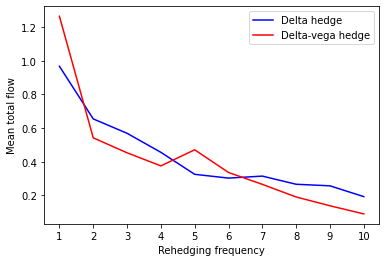

In [132]:
plt.plot(range(1,11),[np.mean(x) for x in changes1], color='blue', label='Delta hedge')
plt.plot(range(1,11),[np.mean(x) for x in changes2], color='red', label='Delta-vega hedge')
plt.xticks(range(1,11))
plt.ylabel('Mean total flow')
plt.xlabel('Rehedging frequency')
plt.legend()
plt.savefig('sep-cost-mean', dpi=1000)

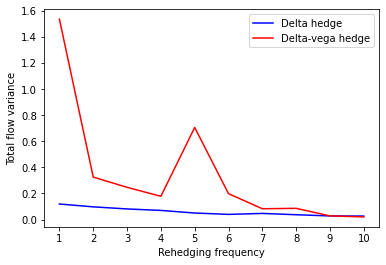

In [131]:
plt.plot(range(1,11),[np.var(x) for x in changes1], color='blue', label='Delta hedge')
plt.plot(range(1,11),[np.var(x) for x in changes2], color='red', label='Delta-vega hedge')
plt.xticks(range(1,11))
plt.ylabel('Total flow variance')
plt.xlabel('Rehedging frequency')
plt.legend()
plt.show()

In [ ]:
delta_vega_hedge_port(1, [-10, 0, 10])

In [105]:
errors3 = []
errors4 = []
for freq in range(1,11):
    print(freq)
    errors3.append(delta_hedge_port(freq, [-10, 0, 10]))
    errors4.append(delta_vega_hedge_port(freq, [-10, 0, 10]))

1
2
3
4
5
6
7
8
9
10


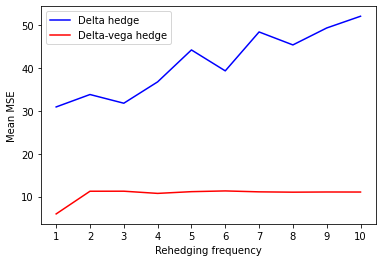

In [106]:
plt.plot(range(1,11),[np.mean(error) for error in errors3], color='blue', label='Delta hedge')
plt.plot(range(1,11),[np.mean([y for y in x if y==y]) for x in errors4], color='red', label='Delta-vega hedge')
plt.xticks(range(1,11))
plt.ylabel('Mean MSE')
plt.xlabel('Rehedging frequency')
plt.legend()
#plt.show()
plt.savefig('port-mean2.jpg', dpi=1000)

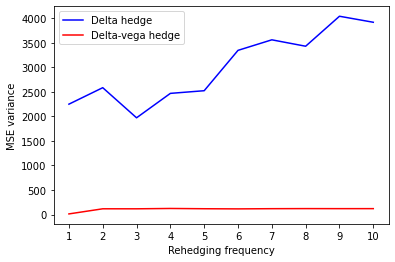

In [107]:
plt.plot(range(1,11),[np.var(error) for error in errors3], color='blue', label='Delta hedge')
plt.plot(range(1,11),[np.var([y for y in x if y==y]) for x in errors4], color='red', label='Delta-vega hedge')
plt.xticks(range(1,11))
plt.ylabel('MSE variance')
plt.xlabel('Rehedging frequency')
plt.legend()
#plt.show()
plt.savefig('port-var2.jpg', dpi=1000)

In [811]:
plt.plot(range(1,6),[np.mean(error) for error in errors3], color='blue', label='Delta hedge')
plt.plot(range(1,6),[np.mean([y for y in x if y==y]) for x in errors4], color='red', label='Delta-vega hedge')
plt.xticks(range(1,6))
plt.ylabel('Mean MSE')
plt.xlabel('Rehedging frequency')
plt.legend()
#plt.show()
plt.savefig('port-mean.jpg', dpi=1000)

,T,515,S,r,date,sigma515
T,,,,,,
45,0.178571,0.01330,0.51394,0.04,21.12.2009,0.138319
44,0.174603,0.01360,0.51515,0.04,22.12.2009,0.136029
43,0.170635,0.01365,0.51544,0.04,23.12.2009,0.136772
42,0.166667,0.01500,0.51816,0.04,24.12.2009,0.136065
41,0.162698,0.01500,0.51816,0.07,25.12.2009,0.119283
40,0.158730,0.01550,0.51913,0.07,28.12.2009,0.120144
39,0.154762,0.01495,0.51875,0.07,29.12.2009,0.118895
38,0.150794,0.01438,0.51890,0.07,30.12.2009,0.112587
37,0.146825,0.01290,0.51409,0.07,31.12.2009,0.135212


In [39]:
errors2 = []
errors3 = []
for freq in range(1,6):
    print(freq)
    errors2.append(delta_hedge_port(freq, [0]))
    errors3.append(delta_vega_hedge_port(freq, [0]))

1
2
3
4
5


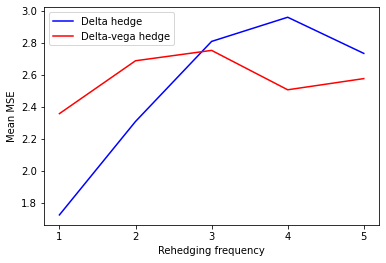

In [41]:
plt.plot(range(1,6),[np.mean(error) for error in errors2], color='blue', label='Delta hedge')
plt.plot(range(1,6),[np.mean([y for y in x if y==y]) for x in errors3], color='red', label='Delta-vega hedge')
plt.xticks(range(1,6))
plt.ylabel('Mean MSE')
plt.xlabel('Rehedging frequency')
plt.legend()
#plt.show()
plt.savefig('single-mean.jpg', dpi=1000)

In [93]:
errors2

[array([ 0.05486623,  0.18377152,  0.02436699,         nan,  2.58738806,
                nan,         nan,  0.46228642,  0.67534249,         nan,
        17.98902994]),
 array([ 0.06159852,  0.2915556 ,  0.03396406,         nan,  2.95414788,
                nan,         nan,  0.46602728,  0.72912757,         nan,
        17.98902994]),
 array([ 0.04339822,  1.27978778,  0.03857793,         nan,  3.29497051,
                nan,         nan,  0.45326135,  0.75338779,         nan,
        17.98902994]),
 array([ 0.04998714,  1.34797568,  0.03963673,         nan,  3.33168101,
                nan,         nan,  0.43125655,  0.70811693,         nan,
        17.98902994]),
 array([ 0.07431728,  1.31900061,  0.05127082,         nan,  3.42382297,
                nan,         nan,  0.80154311,  0.68028482,         nan,
        17.98902994]),
 array([ 0.06391277,  1.43382011,  0.04809644,         nan,  3.2991268 ,
                nan,         nan,  0.47484253,  0.6767435 ,         nan,
        1

In [65]:
def delta_vega_hedge(freq):
    errors = []
    for sheet in range(11):

        E1 = ATM[sheet]
        
        df = read_data('isx2010C.xls', sheet)
        df2 = process(df, [E1])
        
        df = read_data('isx2010C.xls', sheet+1)
        df3 = process(df, [E1])
        
        df4 = pd.merge(df2, df3, on='date')
        
        df4.index = [int(x) for x in df4['T_y']*252]
        df4 = df4.loc[45:]
        #df4 = best_slice(df4)

        i_amounts = []
        o_amounts = []
        day = 0
        for i, row in df4.iterrows():

            if day % freq == 0:

                T1 = row['T_x']
                T2 = row['T_y']
                C1 = row[f'{E1}_x']
                C2 = row[f'{E1}_y']
                S = row['S_x']
                r = row['r_x']
                sigma1 = row[f'sigma{E1}_x']
                sigma2 = row[f'sigma{E1}_y']

                d11 = (np.log(S/(E1/1000)) + (r + 0.5*sigma1**2)*(45/252))/(sigma1*np.sqrt(T1))
                d12 = (np.log(S/(E1/1000)) + (r + 0.5*sigma2**2)*(45/252))/(sigma2*np.sqrt(T2))
                delta1 = norm.cdf(d11)
                delta2 = norm.cdf(d12)
                vega1 = S*np.sqrt(T1)*norm.pdf(d11)
                vega2 = S*np.sqrt(T2)*norm.pdf(d12)

            o_amounts.append(vega1/vega2)
            i_amounts.append(delta1-vega1/vega2*delta2)
            day += 1

        i_amounts = np.array(i_amounts)
        o_amounts = np.array(o_amounts)
        
        option_value_changes = df4[f'{E1}_x'].values[1:] - df4[f'{E1}_x'].values[:-1]
        index_value_changes  = df4['S_x'].values[1:] - df4['S_x'].values[:-1]
        repl_value_changes = df4[f'{E1}_y'].values[1:] - df4[f'{E1}_y'].values[:-1]
        hedge_value_changes  = index_value_changes * i_amounts[:-1] + repl_value_changes*o_amounts[:-1]
        
        # Flip sign of option changes due to the position being short
        differences = (1000*(-option_value_changes + hedge_value_changes))
        error = np.mean(np.square(differences))
        
        errors.append(error)
    
    return np.array(errors)

In [58]:
delta

0.6655706898167991
0.08807404769293309
0.4076602962869232
0.48016875364802714
0.6636404605901907
0.10117939844665969
0.429265504253183
0.4943732718085766
0.6550363821499676
0.10650983009346077
0.4318894320308392
0.4967351597622927
0.656977361597219
0.14665665063820682
0.497256045380725
0.5336552143747448
0.6542129645737484
0.1466381872449809
0.5221516262581251
0.573992658885642
0.644374289739376
0.16713621163491965
0.5470672524494902
0.5896123524236785
0.6306809967633593
0.16644386918027942
0.5317369828150008
0.5792042498654588
0.6181433278465339
0.17261543832678605
0.5325314159765676
0.5822532759572836
0.5732634817573296
0.11085049086838861
0.3979853676258385
0.5008776695093899
0.5592436550842413
0.11483133788751887
0.3998948246616181
0.5097303906490612
0.5610640519397412
0.2915508951013935
0.665099966581732
0.6657868565788243
0.4906461791682241
0.41357462128212563
0.7625242032284942
0.7112041156377311
0.5175362106716005
0.34469894707022875
0.7082668559842006
0.7024975285152978
0.4481

0.7200558726785777
0.028839265669560077
0.39591068599574936
0.5097818575671065
0.7549228975515774
0.039426961096084456
0.4810663389220009
0.5850125612274769
0.6916544156027705
0.030790703254554852
0.3686806191675531
0.48852419400594776
0.7702796730811431
0.06862751615319285
0.572920852849274
0.65468862066539
0.9294317532574833
-0.08639729736975355
0.6519198814228597
0.7943748168759573
1.4725358664736694
-0.5699621684488192
0.8017484131948236
0.9315294879224393
0.9764049625937378
-0.10468640147012265
0.72222194755472
0.8468907683838784
0.7571816995256154
0.10986574372872016
0.6707022568427528
0.7406894718472518
0.7250896176916461
0.12591780239275152
0.6373845858868836
0.7053842325344672
0.5432579182609111
0.12783013673390337
0.44745770541968183
0.5883532626804172
0.475156270465511
0.10139249746474066
0.352472628337247
0.5284159054168073
0.3995692782993866
0.07918253316723461
0.2713090349618727
0.4808340186021079
0.3264927506073131
0.058159838613962206
0.21306142226600677
0.4744411119815

array([5.49115744e-02, 1.29281683e-01, 2.43130689e-02,            nan,
       1.54146932e+00, 4.61766456e-03, 4.71612698e-02, 4.95202803e-01,
       6.75452585e-01,            nan, 1.82463738e+01])

In [95]:
np.nanmean(np.array([1,3,np.nan]))

2.0